# Try HMM

Not entirely sure how these work but will word it out as I go along.


https://towardsdatascience.com/hidden-markov-models-for-time-series-classification-basic-overview-a59b74e5e65b
    Normally towardsdatascience is really good but this makes no sense to me at all.

This article is more complicated, but also indepth and explains stuff more. - https://towardsdatascience.com/markov-chains-and-hmms-ceaf2c854788

Some guys github repository using HMM for binary sentimental analysis of tweets - https://github.com/FantacherJOY/Hidden-Markov-Model-for-NLP


"In the case one label is way more frequent than the other (say Class B appears for every 100 samples of Class A), or in the case one category is broader than the other (have more variance, i.e. Class A is an expected behavior of a process and Class B is all the cases that are abnormal), then we might want to train a unique HMM for Class A. For each new sample, we compute the likelihood to the model, and if it falls below a pre-defined threshold (that can be chosen with respect to some validation sample, or in the worst case, from the training samples themselves) we assign this sample to Class B. If the likelihood is above the threshold, we assign the sample to Class A." - https://datascience.stackexchange.com/questions/8560/can-hmm-be-used-as-a-binary-classifier

In [1]:
# imports
from hmmlearn import hmm
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

# Load in data
# index_col stops index being read as column
df_turk = pd.read_csv('turk-Data-renamed.csv', index_col=0)
df_lab = pd.read_csv('lab-Data-renamed.csv', index_col=0)

In [2]:
# Load in data

# Data Engineering

Initial exploration shown to be promising.
Now do some data engineering to get the targets into the format I want.

In [3]:
# First get the targets data in a time series of time, target, and ID.

# When we remove the mouse event we have much more duplicate data.
# Drop this data and reset the indexes to account for missing values.
# Since there was a correlation between time and number of mouse events maybe I can use index to substitue for time.

df_m_lab = df_lab[['target', 'time', 'turkId']]     # m for markov
lab_dups = len(df_m_lab)-len(df_m_lab.drop_duplicates())
print(f'Number of duplicate items in lab data: {lab_dups}')
print(f'Percentage duplicate: {lab_dups / len(df_lab) * 100}\n')
df_m_lab = df_m_lab.drop_duplicates()

df_m_turk = df_turk[['target', 'time', 'turkId']]
turk_dups = len(df_m_turk)-len(df_m_turk.drop_duplicates())
print(f'Number of duplicate items in turk data: {turk_dups}')
print(f'Percentage duplicate: {turk_dups / len(df_m_turk) * 100}')
df_m_turk = df_m_turk.drop_duplicates()

df_m_lab

Number of duplicate items in lab data: 9482
Percentage duplicate: 25.309630578688875

Number of duplicate items in turk data: 180378
Percentage duplicate: 21.656231428176945


,target,time,turkId
0,alloc-slider-5,0.000000,ID1
1,alloc-slider-5,0.547000,ID1
3,alloc-slider-5,1.176995,ID1
4,alloc-slider-5,1.790000,ID1
5,html,2.896995,ID1
...,...,...,...
58261,alloc-slider-2,273.796495,ID18
58263,alloc-slider-2,273.836415,ID18
58265,alloc-slider-2,273.924560,ID18
58270,html,274.968440,ID18


In [4]:
# TODO: Might have to convert targets to numerical representation, maybe one-hot encoding?

# Replace html with 0, and alloc-slider-1 to 1, alloc-slider-2 to 2, alloc-slider-3 to 3, alloc-slider-4 to 4, alloc-slider-5 to 5

df_m_lab.loc[df_m_lab['target'].str.contains('html'), 'target'] = '0'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-1'), 'target'] = '1'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-2'), 'target'] = '2'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-3'), 'target'] = '3'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-4'), 'target'] = '4'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-5'), 'target'] = '5'
m_lab = df_m_lab['target'].to_numpy().reshape(-1, 1)

df_m_turk.loc[df_m_turk['target'].str.contains('html'), 'target'] = '0'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-1'), 'target'] = '1'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-2'), 'target'] = '2'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-3'), 'target'] = '3'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-4'), 'target'] = '4'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-5'), 'target'] = '5'
m_turk = df_m_turk['target'].astype('int32').to_numpy().reshape(-1, 1)
m_turk.shape

(652537, 1)

In [5]:
# we want to have everything in one long array like this.
# But then we need to create the lengths array thing.

lab_lengths = []
for ID in df_m_lab['turkId'].unique():
    length_for_ID = len( df_m_lab[df_m_lab['turkId'] == ID] )
    lab_lengths.append(length_for_ID)

turk_lengths = []
for ID in df_m_turk['turkId'].unique():
    length_for_ID = len( df_m_turk[df_m_turk['turkId'] == ID] )
    turk_lengths.append(length_for_ID)

lab_lengths

[2267,
 2341,
 2341,
 646,
 597,
 3116,
 1531,
 490,
 2666,
 469,
 3754,
 3754,
 2005,
 2005]

In [6]:
# Create Lab data HMM

# Suggestions for number of hidden states.
# https://www.researchgate.net/post/Is_there_any_simple_rule_for_the_number_of_states_in_HMM

lab_model = hmm.GaussianHMM(n_components=6).fit(m_lab, lab_lengths) # dont know how many components/hidden states I should have
lab_model

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=6, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

In [7]:
lab_model.sample(10)

(array([[ 0.03298651],
        [-0.01427365],
        [ 0.0426164 ],
        [ 0.00374288],
        [ 0.01448445],
        [-0.02236808],
        [ 1.99785084],
        [ 1.99713603],
        [ 2.00148133],
        [ 2.00063751]]),
 array([5, 5, 5, 5, 5, 5, 3, 3, 3, 3]))

In [8]:
# Lab Transition Matrix
np.round(lab_model.transmat_, 3)

array([[0.953, 0.001, 0.012, 0.002, 0.019, 0.014],
       [0.003, 0.941, 0.007, 0.027, 0.005, 0.017],
       [0.019, 0.005, 0.942, 0.018, 0.005, 0.011],
       [0.002, 0.015, 0.02 , 0.948, 0.004, 0.012],
       [0.021, 0.005, 0.005, 0.006, 0.948, 0.015],
       [0.015, 0.025, 0.015, 0.013, 0.018, 0.913]])

In [9]:
turk_model = hmm.GaussianHMM(n_components=6).fit(m_turk.reshape(-1, 1), turk_lengths) # dont know how many components/hidden states I should have
turk_model

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=6, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

In [10]:
np.round(turk_model.transmat_, 2)

array([[0.93, 0.03, 0.  , 0.01, 0.  , 0.02],
       [0.02, 0.93, 0.01, 0.02, 0.01, 0.02],
       [0.  , 0.02, 0.95, 0.  , 0.  , 0.01],
       [0.01, 0.02, 0.  , 0.95, 0.01, 0.  ],
       [0.  , 0.02, 0.  , 0.02, 0.95, 0.  ],
       [0.01, 0.02, 0.02, 0.01, 0.  , 0.94]])

In [11]:
np.round(np.array(turk_model.sample(10)[0]).reshape(-1),2)

#turk_model.sample(10)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [12]:
#for i in range(len(lab_lengths)):
#    print( turk_model.score( m_lab[i].reshape(-1, 1) ) )

# Have to have all this extra code because the data is stored in a big long list so need to kind of extract the user details again.

def model_score_list(model, data, lengths):
    # Given a model and some data and lengths return a list of predict_probas that each different data sample belongs to that HMM.

    probas = []

    start_i = 0
    #end_i = start_i + lab_lengths[0]
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]
        
        #print(i)
        #print( model.score( users_items ) )
        probas.append( model.score(users_items) )

        start_i = lengths[i] # lab_lengths[0]
        #end_i = start_i + lab_lengths[i+1]

    return probas

model_score_list(turk_model, m_lab, lab_lengths)    # Try lab data on turk model

[15321.819068804787,
 15933.351630941224,
 15935.68508752883,
 4296.340267087065,
 4073.787478618264,
 21229.521961676954,
 10521.516918091533,
 3380.520003529126,
 18104.632754821636,
 3181.3101293348727,
 25630.308427388878,
 25590.183258763027,
 13596.270240146147,
 13605.720619407246]

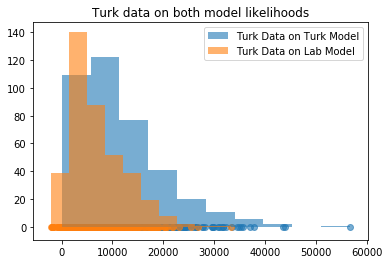

In [13]:
turk_data_turk_model = model_score_list(turk_model, m_turk, turk_lengths)  # Try turk data on turk model
turk_data_lab_model = model_score_list(lab_model, m_turk, turk_lengths)  # Try turk data on lab model

plt.hist(turk_data_turk_model, bins=10, label='Turk Data on Turk Model', alpha=0.6)
plt.hist(turk_data_lab_model, bins=10, label='Turk Data on Lab Model', alpha=0.6)

plt.title('Turk data on both model likelihoods')
plt.legend(loc='best')

# Also show the individual points on there too because why not.
plt.scatter( turk_data_turk_model, np.zeros((len(turk_data_turk_model),1)), label='Turk Data on Turk Model', alpha=0.6 )
plt.scatter( turk_data_lab_model, np.zeros((len(turk_data_lab_model),1)), label='Turk Data on Lab Model', alpha=0.6 )

plt.show()

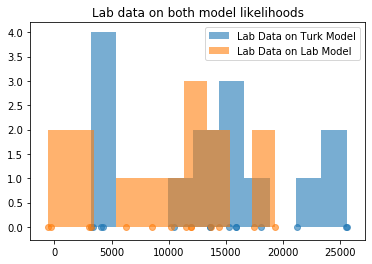

In [14]:
lab_data_turk_model = model_score_list(turk_model, m_lab, lab_lengths)  # Try lab data on turk model
lab_data_lab_model = model_score_list(lab_model, m_lab, lab_lengths)  # Try lab data on lab model

plt.hist(lab_data_turk_model, bins=10, label='Lab Data on Turk Model', alpha=0.6)
plt.hist(lab_data_lab_model, bins=10, label='Lab Data on Lab Model', alpha=0.6)

plt.title('Lab data on both model likelihoods')
plt.legend(loc='best')

# Also show the individual points on there too because why not.
plt.scatter( lab_data_turk_model, np.zeros((len(lab_data_turk_model),1)), label='Lab Data on Turk Model', alpha=0.6 )
plt.scatter( lab_data_lab_model, np.zeros((len(lab_data_lab_model),1)), label='Lab Data on Lab Model', alpha=0.6 )

plt.show()

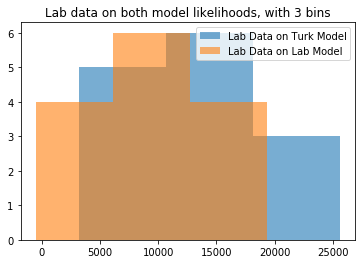

In [15]:
# This graph clearly shows that on average, the lab data is more likely to be classified as a turk model.

plt.hist(lab_data_turk_model, bins=3, label='Lab Data on Turk Model', alpha=0.6)
plt.hist(lab_data_lab_model, bins=3, label='Lab Data on Lab Model', alpha=0.6)

plt.title('Lab data on both model likelihoods, with 3 bins')
plt.legend(loc='best')
plt.show()

# AMAZING IDEA

hmmlearn has the function .SAMPLE(n). This Generates random samples from the model.

With some effort could potentially use this to generate new samples for lab data!

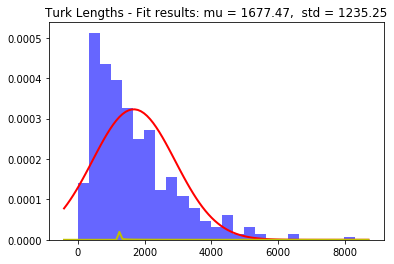

In [16]:
# See if lab_lengths follow a normal distribution
# Lab lengths kind of follow this distribution but not really.
#https://stackoverflow.com/questions/20011122/fitting-a-normal-distribution-to-1d-data

from scipy.stats import norm
from scipy.stats import lognorm

mu, std = norm.fit(turk_lengths)

plt.hist(turk_lengths, bins=25, density=True, alpha=0.6, color='b')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

p2 = lognorm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
plt.plot(x, p2, 'y', linewidth=2)
title = "Turk Lengths - Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

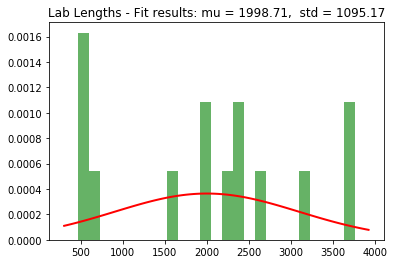

In [17]:
# See if Lab data follows a distrinution

mu, std = norm.fit(lab_lengths)

plt.hist(lab_lengths, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = "Lab Lengths - Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

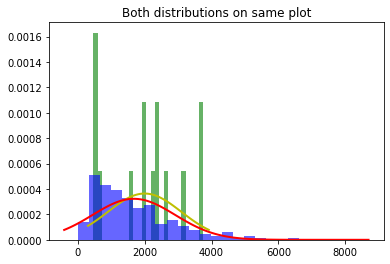

In [18]:
# Both on 1 graph?

mu, std = norm.fit(lab_lengths)

plt.hist(lab_lengths, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'y', linewidth=2)
plt.title('Both distributions on same plot')

mu, std = norm.fit(turk_lengths)

plt.hist(turk_lengths, bins=25, density=True, alpha=0.6, color='b')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)

plt.show()

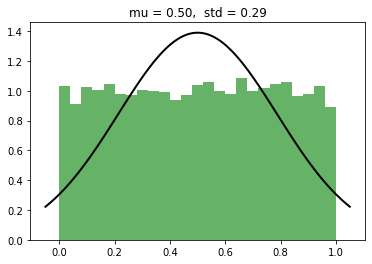

In [19]:
#Showing how a random uniform variable can still look like a gaussian   

x = np.random.rand(10000)

# See if Lab data follows a distrinution

mu, std = norm.fit(x)

plt.hist(x, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

Text(0.5, 1.0, 'Both Lengths - Fit results: mu = 1688.63,  std = 1232.06')

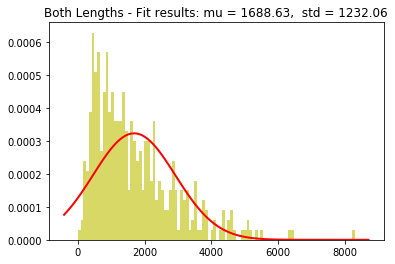

In [20]:
# Combine both data together and see what the distribution looks like
# Probably a bit pointless as the turk data will still be so much more numerous

both_lengths = np.append(turk_lengths,lab_lengths)
both_lengths = np.array(np.append(turk_lengths,lab_lengths), dtype=float)

mu, std = norm.fit(both_lengths)

plt.hist(both_lengths, bins=100, density=True, alpha=0.6, color='y')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = "Both Lengths - Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

# Length Distributions.
Thought this would be a failure at first but this is actually really amazing!
Can CLEARLY see a distribution off turk lengths, and we could explain you not seeing a distribtion in lab data because there is so little many samples.

For Turk and Lab the means are:

|  | Mean | S.D |
| --- | --- | --- |
| Turk | 1677 | 1235 |
| Lab | 1998 | 1095 |

Which are not identical, but as I've showed with the ealier PCA attempts lengths cannot be used to differenciate data points.
Theyre similar enough that I can assume they follow the SAME distribtion.


# Synthesize data
We can generate sequences of any length specified.
todo sample length from a normal distribution matching the lab or turk data depending on what class im creating more samples for.

At the moment this section creates fixed length samples but that will change.

In [21]:
# Lab Data

from statistics import mean
ave_lab_length = int(np.round(mean(lab_lengths),0) ) # Ave length to nearest whole number
print( ave_lab_length )
print( lab_lengths )

# Now sample points 1999 times to get a created lab data distributions.
# np.round(np.array(turk_model.sample(10)[0]).reshape(-1),2)

created_data = []

# Create 10 data samples
for i in range(5):
    created_data.append( np.round(lab_model.sample(ave_lab_length)[0],0) )


1999
[2267, 2341, 2341, 646, 597, 3116, 1531, 490, 2666, 469, 3754, 3754, 2005, 2005]


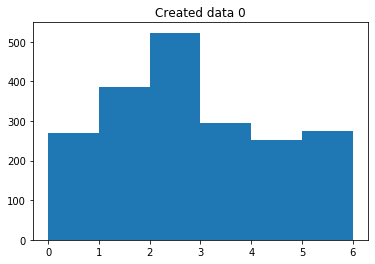

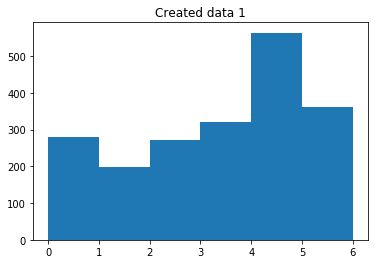

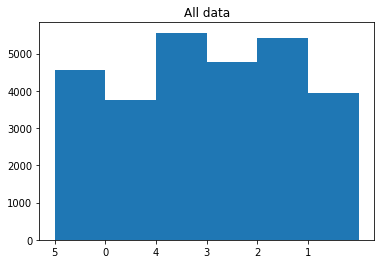

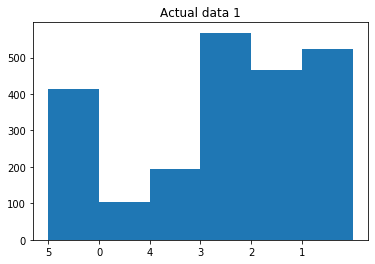

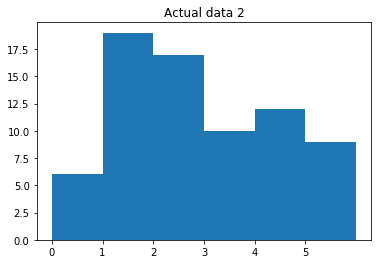

In [22]:
plt.hist(created_data[0], bins=[0,1,2,3,4,5,6])
plt.title('Created data 0')
plt.show()
plt.hist(created_data[1], bins=[0,1,2,3,4,5,6])
plt.title('Created data 1')
plt.show()


plt.hist(m_lab, bins=[0,1,2,3,4,5,6])
plt.title('All data')
plt.show()

plt.hist(m_lab[:lab_lengths[0]], bins=[0,1,2,3,4,5,6])
plt.title('Actual data 1')
plt.show()
plt.hist(m_lab[lab_lengths[0]+1:lab_lengths[1]], bins=[0,1,2,3,4,5,6])
plt.title('Actual data 2')
plt.show()

In [23]:
# Turk created Data
ave_turk_length = int(np.round(mean(turk_lengths),0) ) # Ave length to nearest whole number
print( ave_turk_length )
print( turk_lengths[:10] )

# Now sample points 1999 times to get a created turk data distributions.
# np.round(np.array(turk_model.sample(10)[0]).reshape(-1),2)

turk_created_data = []

# Create 300 data samples
for i in range(300):
    turk_created_data.append( np.round(turk_model.sample(ave_turk_length)[0],0) )



1677
[365, 608, 1005, 801, 178, 292, 430, 812, 2545, 1009]


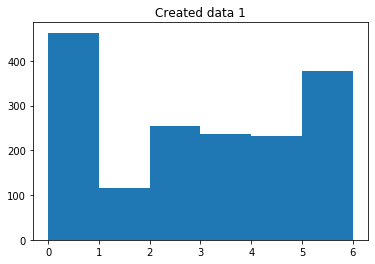

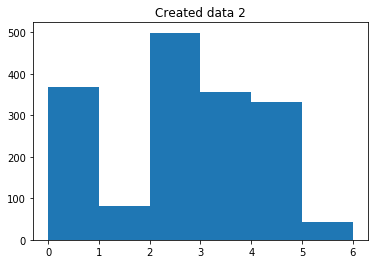

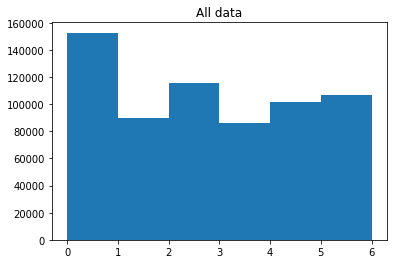

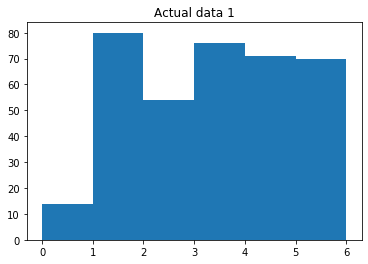

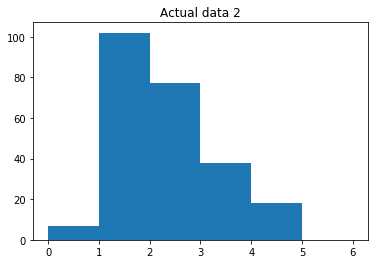

In [24]:

# Visualize created Data.

plt.hist(turk_created_data[0], bins=[0,1,2,3,4,5,6])
plt.title('Created data 1')
plt.show()
plt.hist(turk_created_data[1], bins=[0,1,2,3,4,5,6])
plt.title('Created data 2')
plt.show()


plt.hist(m_turk, bins=[0,1,2,3,4,5,6])
plt.title('All data')
plt.show()

plt.hist(m_turk[:turk_lengths[0]], bins=[0,1,2,3,4,5,6])
plt.title('Actual data 1')
plt.show()
plt.hist(m_turk[turk_lengths[0]+1:turk_lengths[1]], bins=[0,1,2,3,4,5,6])
plt.title('Actual data 2')
plt.show()

In [25]:
df_turk_created = pd.DataFrame.from_records( turk_created_data )
#df_turk_created.replace([0.0],'html')
df_turk_created = df_turk_created.replace(0,'html')
df_turk_created = df_turk_created.replace(1,'alloc-slider-1')
df_turk_created = df_turk_created.replace(2,'alloc-slider-2')
df_turk_created = df_turk_created.replace(3,'alloc-slider-3')
df_turk_created = df_turk_created.replace(4,'alloc-slider-4')
df_turk_created = df_turk_created.replace(5,'alloc-slider-5')

In [26]:
created_turk_array = np.array(turk_created_data)
df_turk_created = pd.DataFrame(created_turk_array.flatten())

# Need to create a list of ID's that our generated samples can use.
gen_ids = []
for i in range(300): # 300 new samples created
    gen_ids.append([i]*ave_turk_length)
gen_ids = np.array(gen_ids).flatten()

df_turk_created['turkId'] = gen_ids
df_turk_created.columns = ['target', 'turkId']


df_turk_created['target'] = df_turk_created['target'].replace(0,'html')
df_turk_created['target'] = df_turk_created['target'].replace(1,'alloc-slider-1')
df_turk_created['target'] = df_turk_created['target'].replace(2,'alloc-slider-2')
df_turk_created['target'] = df_turk_created['target'].replace(3,'alloc-slider-3')
df_turk_created['target'] = df_turk_created['target'].replace(4,'alloc-slider-4')
df_turk_created['target'] = df_turk_created['target'].replace(5,'alloc-slider-5')
df_turk_created

,target,turkId
0,html,0
1,html,0
2,alloc-slider-5,0
3,alloc-slider-5,0
4,alloc-slider-5,0
...,...,...
503095,html,299
503096,html,299
503097,alloc-slider-1,299
503098,alloc-slider-1,299
